In [7]:
import SimpleITK as sitk
import glob
import matplotlib.pyplot as plt
import numpy as np
import random


import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

import pickle

In [5]:
# All Functions

def resample_image(itk_image, out_spacing=(1.0, 1.0, 1.5), is_label=False):
    original_spacing = itk_image.GetSpacing()
    original_size    = itk_image.GetSize()

    #print(original_size[0], original_spacing[0], out_spacing[0], 128, original_size[0]*(original_spacing[0]))
    
    out_size = [int(np.round(original_size[0]*(original_spacing[0]/out_spacing[0]))),
                int(np.round(original_size[1]*(original_spacing[1]/out_spacing[1]))),
                int(np.round(original_size[2]*(original_spacing[2]/out_spacing[2])))]
    #print(out_size)
    #out_size = [128, 128, 128]
    resample = sitk.ResampleImageFilter()
    resample.SetNumberOfThreads(12)
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(0)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        #resample.SetInterpolator(sitk.sitkBSpline)
        resample.SetInterpolator(sitk.sitkLinear)

    return resample.Execute(itk_image)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            #nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            #nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class SUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(SUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(128, 64 // factor, bilinear)
        self.up3 = Up(64, 32 // factor, bilinear)
        self.up4 = Up(32, 16, bilinear)
        self.outc = OutConv(16, n_classes)
        #self.out_sigmoid = nn.Sigmoid()
        #self.out_softmax = nn.LogSoftmax(dim=1)
        
        self.gn1 = nn.GroupNorm(8, 16)
        self.gn2 = nn.GroupNorm(16, 32)
        self.gn3 = nn.GroupNorm(32, 64)
        self.gn4 = nn.GroupNorm(64, 128)
        self.gn5 = nn.GroupNorm(32, 64)
        self.gn6 = nn.GroupNorm(16, 32)
        self.gn7 = nn.GroupNorm(8, 16)
    
    def forward(self, x):
        x1 = self.inc(x)
        x1 = self.gn1(x1)
       
        x2 = self.down1(x1)
        x2 = self.gn2(x2)
       
        x3 = self.down2(x2)
        x3 = self.gn3(x3)
       
        x4 = self.down3(x3)
        x4 = self.gn4(x4)
       
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.gn5(x)
       
        x = self.up2(x, x3)
        x = self.gn6(x)
       
        x = self.up3(x, x2)
        x = self.gn7(x)
       
        x = self.up4(x, x1)
        logits = self.outc(x)
        #out    = self.out_softmax(logits)
        return logits

#model = SUNet(1, 1)
#model.cuda()

In [ ]:
#For storing the file hash

# allfiles  = open('/media/pranjal/BackupPlus/MandM1/mandm_list.csv').read().split('\n')[:-1]
# file_hash = {}

# for t in allfiles:
#     print(t)
#     file_hash[t.split(',')[0]] = [t.split(',')[1], int(t.split(',')[2]), int(t.split(',')[3]), int(t.split(',')[4])]

# import pickle

# output = open('/media/pranjal/BackupPlus/MandM1/file_hash.pkl', 'wb')
# pickle.dump(file_hash, output)
# output.close()

# # read python dict back from the file
# pkl_file = open('/media/pranjal/BackupPlus/MandM1/file_hash.pkl', 'rb')
# file_hash = pickle.load(pkl_file)
# pkl_file.close()

In [8]:
# For creating the numpy array of Training Set

pkl_file = open('/media/pranjal/BackupPlus/MandM1/file_hash.pkl', 'rb')
file_hash = pickle.load(pkl_file)
pkl_file.close()

a = glob.glob('/media/pranjal/BackupPlus/MandM1/*_sa.nii.gz')
print(len(a))

trainx = []
trainy = []

count = 0
for t in a:
    hash_result = file_hash[str(t.split('/')[-1].split('_')[0])]
    if hash_result[0] == 'A':
        vol_img  = sitk.ReadImage(t)
        mask_img = sitk.ReadImage(t.replace('_sa.nii.gz', '_sa_gt.nii.gz'))
        
        vol     = sitk.GetArrayFromImage(vol_img)
        mask    = sitk.GetArrayFromImage(mask_img)
        
        vol  = vol[hash_result[2]]
        mask = mask[hash_result[2]]
        
        mask_img1 = sitk.GetImageFromArray(mask)
        mask_img1.SetSpacing(mask_img.GetSpacing()[:3])
        
        vol_img1  = sitk.GetImageFromArray(vol)
        vol_img1.SetSpacing(mask_img.GetSpacing()[:3])
        
        vol_img2  =  resample_image(vol_img1, (2, 2, 2))
        mask_img2 =  resample_image(mask_img1, (2, 2, 2), is_label=True)
        
        vol  = sitk.GetArrayFromImage(vol_img2)
        mask = sitk.GetArrayFromImage(mask_img2)
        
        print(count, t.split('/')[-1].split('_')[0], hash_result, vol_img2.GetSize(), mask_img2.GetSize())
        
        for k in range(mask.shape[0]):
            if np.count_nonzero(mask[k].flatten()) > 0:
                temp = vol[k]
                midy = int(temp.shape[1]/2)
                sz = sy  = np.max([0,   midy-80])
                ez = ey  = np.min([160, midy+80])
                temp = temp[sy:sy+160, sz:sz+160]
                
                temp1 = mask[k]
                temp1 = temp1[sy:sy+160, sz:sz+160]
                
                sx = np.max(int((160-temp.shape[0])/2), 0)
                sy = np.max(int((160-temp.shape[1])/2), 0)

                temp = np.pad(temp, ((sx, 160-temp.shape[0]-sx), (sy, 160-temp.shape[1]-sy)), 'constant')
                trainx.append(np.expand_dims(temp, 0)/1024.0)
                
                temp1 = np.pad(temp1, ((sx, 160-temp1.shape[0]-sx), (sy, 160-temp1.shape[1]-sy)), 'constant')
                trainy.append(np.expand_dims(temp1, 0))
                #print(temp.shape, temp1.shape)
                #print(temp.shape)
                #trainx.append(vol[k])
                #trainy.append(mask[k])
        
        count = count+1
        
trainx = np.array(trainx)
trainy = np.array(trainy)


valx = trainx[int(trainx.shape[0]*0.8):]
valy = trainy[int(trainy.shape[0]*0.8):]

trainx = trainx[:int(trainx.shape[0]*0.8)]
trainy = trainy[:int(trainy.shape[0]*0.8)]


print(trainx.shape, trainy.shape)
print(valx.shape,   valy.shape)

150
0 K4T7Y0 ['A', 1, 24, 12] (130, 160, 36) (130, 160, 36)
1 A1E9Q1 ['A', 1, 0, 9] (102, 125, 65) (102, 125, 65)
2 K5P0Y1 ['A', 1, 0, 9] (159, 195, 67) (159, 195, 67)
3 D3O9U9 ['A', 1, 0, 10] (130, 160, 24) (130, 160, 24)
4 C2J0K3 ['A', 1, 0, 9] (130, 160, 48) (130, 160, 48)
5 C0K1P0 ['A', 1, 0, 9] (139, 170, 58) (139, 170, 58)
6 B4O3V3 ['A', 1, 0, 6] (130, 160, 40) (130, 160, 40)
7 G4S9U3 ['A', 1, 0, 11] (139, 170, 67) (139, 170, 67)
8 A6D5F9 ['A', 1, 0, 11] (135, 160, 52) (135, 160, 52)
9 M2P1R1 ['A', 1, 0, 10] (118, 145, 40) (118, 145, 40)
10 B0I2Z0 ['A', 1, 0, 8] (170, 139, 58) (170, 139, 58)
11 B8H5H6 ['A', 1, 24, 8] (139, 170, 58) (139, 170, 58)
12 Q0U0V5 ['A', 1, 0, 10] (139, 170, 58) (139, 170, 58)
13 B2C2Z7 ['A', 1, 0, 8] (122, 150, 77) (122, 150, 77)
14 C5M4S2 ['A', 1, 0, 9] (170, 139, 58) (170, 139, 58)
15 T9U9W2 ['A', 1, 0, 10] (130, 160, 44) (130, 160, 44)
16 H1I3W0 ['A', 1, 0, 9] (148, 175, 40) (148, 175, 40)
17 D8E4F4 ['A', 1, 0, 10] (170, 139, 58) (170, 139, 58)
18 J8R

In [19]:
# For trainng the Model for segmentation

# [STAR] For training Single U-Net pytorch in a loop

import torch.optim as optim
from tqdm import tqdm
import random
from skimage.transform import rotate, AffineTransform, warp


def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum()+0.00001)

def dice_loss(pred, target, smooth = 1.):
    pred = F.sigmoid(pred)
    
    pred   = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

# basepath       = '/media/yu-hao/WindowsData/COVID_MOSCOW/COVID_MOSCOW/COVID19_1110/'
# train_ids      = np.load(basepath+'TRAIN.npy')
# val_ids        = np.load(basepath+'VALIDATION.npy')
# test_ids       = np.load(basepath+'TEST.npy')
# unlabelled_ids = np.load(basepath+'NOTLABELLED.npy')

# train_ids      = train_ids[:4]
# trainx, trainy = read_training_data(train_ids)
# valx, valy     = read_training_data(val_ids)
# testx, testy   = read_training_data(test_ids)

basepath = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/MandM/'

modelname = 0


model = SUNet(1, 4)
model.cuda()
    
if modelname == 0:
    #basepath+"models/unet_A_"+str(modelname)+".pt"
    p1 = torch.load(basepath+"models/unet_A_"+str(modelname)+".pt")
    model.load_state_dict(p1)
#p1 = torch.load('/media/dril/New Volume/COVID_MOSCOW/unet_6.pt')
#model.load_state_dict(p1)

device    = torch.device("cuda:0")
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss(torch.ones([1]).cuda())
prev_min  = -1
    
train_loss_array = []
val_loss_array   = []

train_dice_array = []
val_dice_array   = []
    
for epoch in range(100):
    model.train()
    loss_array = []

    train_y_true = []
    train_y_pred = []

    #print('training')
    batch_size = 4
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :, :, :]
        y = trainy[i*batch_size:(i+1)*batch_size, 0, :, :]
        #y = trainy[i*batch_size:(i+1)*batch_size, :, :, :]

        for k in range(x.shape[0]):
            rotv = random.randint(0, 3)
            x[k, 0, :, :] = np.rot90(x[k, 0, :, :], rotv)#rotate(x[k, 0, :, :], angle=angle, mode = 'wrap')
            y[k, :, :] = np.rot90(y[k, :, :], rotv)#rotate(y[k, 0, :, :], angle=angle, mode = 'wrap')

        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).long()
        #y = torch.tensor(y, device=device).float()

        optimizer.zero_grad()
        output = model.forward(x)
        
        loss = criterion(output , y)
        loss.backward()
        loss_array.append(loss.item())
        optimizer.step()
        
        output = F.log_softmax(output, dim=1)
        #output = torch.nn.LogSoftmax(output)
        output = np.argmax(output.data.cpu().numpy(), 1)
        #output = output.data.cpu().numpy()
        y      = y.data.cpu().numpy()
        
        #output[output < 0.5] = 0
        #output[output > 0.5] = 1

        for pk in range(output.shape[0]):
            train_dice_array.append(dice(y[pk, :, :], output[pk, :, :]))
    
    train_loss = np.mean(loss_array)

    model.eval()

    val_y_true   = []
    val_y_pred   = []

    loss_array_val = []
    batch_size     = 1
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :, :, :]
        y = valy[ik*batch_size:(ik+1)*batch_size, 0, :, :]
        #y = valy[ik*batch_size:(ik+1)*batch_size, :, :, :]

        x = torch.tensor(x, device=device).float()
        #y = torch.tensor(y, device=device).float()
        y = torch.tensor(y, device=device).long()

        output = model.forward(x)
        #output = 
        loss   = criterion(output , y)#torch.max(y, 1)[1])
        loss_array_val.append(loss.item())
        #torch.nn.LogSoftmax

        output = F.log_softmax(output, dim=1)
        #output = torch.nn.LogSoftmax(output)
        #output = torch.sigmoid(output)
        #output = output.data.cpu().numpy()
        #y      = y.data.cpu().numpy()

        #output = output.data.cpu().numpy()
        output = np.argmax(output.data.cpu().numpy(), 1)
        y      = y.data.cpu().numpy()

        #output[output < 0.5] = 0
        #output[output > 0.5] = 1

        for pk in range(output.shape[0]):
            val_dice_array.append(dice(y[pk, :, :], output[pk, :, :]))

        for k in output:
            val_y_pred.append(k[0])
        for k in y:
            val_y_true.append(k[0])

    val_y_true = np.array(val_y_true)#.astype('uint8')
    val_y_pred = np.array(val_y_pred)#.astype('uint8')

    val_loss = np.mean(loss_array_val)
    print("Epoch %d -> Train loss %.5f, Val Loss %.5f Train Dice %.5f, Val Dice %.5f" % (epoch, train_loss, val_loss, np.mean(train_dice_array), np.mean(val_dice_array)))

    train_loss_array.append(train_loss)
    val_loss_array.append(val_loss)

    if np.mean(val_dice_array) > prev_min:
        print('Saving Model ', np.mean(val_dice_array), prev_min)
        prev_min = np.mean(val_dice_array)
        torch.save(model.state_dict(), basepath+"models/unet_A_"+str(modelname)+".pt")
        #if epoch == 0:
        #    temp1_img = sitk.GetImageFromArray(val_y_true)
        #    sitk.WriteImage(temp1_img, basepath+'models/true_new_'+str(modelname)+'_'+str(epoch)+'.nii.gz')

Epoch 0 -> Train loss 0.01187, Val Loss 0.05328 Train Dice 0.96034, Val Dice 0.86444
Saving Model  0.8644427933320682 -1
Epoch 1 -> Train loss 0.01185, Val Loss 0.05196 Train Dice 0.96014, Val Dice 0.86623
Saving Model  0.8662311878768725 0.8644427933320682
Epoch 2 -> Train loss 0.01191, Val Loss 0.05376 Train Dice 0.95970, Val Dice 0.86417
Epoch 3 -> Train loss 0.01199, Val Loss 0.04285 Train Dice 0.95994, Val Dice 0.86601
Epoch 4 -> Train loss 0.01197, Val Loss 0.04351 Train Dice 0.95996, Val Dice 0.86666
Saving Model  0.8666606055940439 0.8662311878768725
Epoch 5 -> Train loss 0.01182, Val Loss 0.05080 Train Dice 0.96002, Val Dice 0.86516
Epoch 6 -> Train loss 0.01231, Val Loss 0.04420 Train Dice 0.95972, Val Dice 0.86580
Epoch 7 -> Train loss 0.01107, Val Loss 0.04638 Train Dice 0.96012, Val Dice 0.86692
Saving Model  0.8669185880336117 0.8666606055940439
Epoch 8 -> Train loss 0.01134, Val Loss 0.04437 Train Dice 0.96035, Val Dice 0.86716
Saving Model  0.867159194360937 0.866918588

Epoch 87 -> Train loss 0.00796, Val Loss 0.06886 Train Dice 0.96860, Val Dice 0.86747
Saving Model  0.8674689803897533 0.8673923087477842
Epoch 88 -> Train loss 0.00778, Val Loss 0.06988 Train Dice 0.96866, Val Dice 0.86753
Saving Model  0.8675272209028619 0.8674689803897533
Epoch 89 -> Train loss 0.00779, Val Loss 0.07278 Train Dice 0.96873, Val Dice 0.86761
Saving Model  0.8676067249281717 0.8675272209028619
Epoch 90 -> Train loss 0.00774, Val Loss 0.07612 Train Dice 0.96879, Val Dice 0.86761
Saving Model  0.8676148934932131 0.8676067249281717
Epoch 91 -> Train loss 0.00765, Val Loss 0.07707 Train Dice 0.96886, Val Dice 0.86763
Saving Model  0.8676258943930629 0.8676148934932131
Epoch 92 -> Train loss 0.00761, Val Loss 0.06968 Train Dice 0.96892, Val Dice 0.86769
Saving Model  0.8676948216764371 0.8676258943930629
Epoch 93 -> Train loss 0.00764, Val Loss 0.08049 Train Dice 0.96899, Val Dice 0.86769
Epoch 94 -> Train loss 0.00774, Val Loss 0.07712 Train Dice 0.96905, Val Dice 0.86762


In [16]:
print(output)

LogSoftmax()


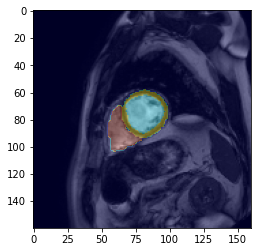

In [188]:
index2 = random.randint(0, trainx.shape[0]-1)

plt.imshow(trainx[index2], cmap='gray')
plt.imshow(trainy[index2], cmap='jet', alpha=0.3)